In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from os.path import join
from os import makedirs
from common import get_traces_path, get_monitor_path, method_aliases, method_fname, aliases_to_method_names, parse_stead_snr, detector, cropoffset_filter, snr_filter

In [7]:
KFOLD = 5
EXP_RESULTS_DIR = "../results"
MODELS_CSV = "../evals/df_best_rocauc.csv"
PLOT_PATH = "../rocs/best_rocauc.pdf"
MAX_SNR = np.inf
SPLITS = range(KFOLD)

In [8]:
def plot_density(df_traces, metric):
    plt.clf()
    plt.figure(figsize=(10, 8))
    sns.kdeplot(data=df_traces, hue="label", x=df_traces[metric], bw_adjust=0.05)

def plot_roc(models):
    plt.clf()
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_ylim([0.0, 1])
    
    for model in models:
        ax.plot(model["fpr"],  model["tpr"], label =model["name"], linewidth=1)
    
    ax.legend()

def get_mean_roc(tprs, fprs):
    # Find the maximum and minimum lengths among all folds
    max_len = max(len(tpr) for tpr in tprs)
    min_len = min(len(tpr) for tpr in tprs)

    # Create new arrays with the maximum length
    new_tprs = []
    new_fpr = np.linspace(0, 1, max_len)

    # Interpolate or resample the data for each fold to match the maximum length
    for tpr, fpr in zip(tprs, fprs):
        roc_auc1 = auc(fpr, tpr)

        interpolated_tpr = np.interp(new_fpr, fpr, tpr)
        new_tprs.append(interpolated_tpr)
        roc_auc2 = auc(new_fpr, interpolated_tpr)

        print("AUC1: {}, AUC2: {}".format(roc_auc1, roc_auc2))

    # Calculate the average TPR and FPR
    avg_tpr = np.mean(np.array(new_tprs), axis=0)
    avg_fpr = new_fpr

    return avg_tpr, avg_fpr

In [9]:
EVALS = []
df = pd.read_csv(MODELS_CSV)

df.sort_values(["Method", "Training", "Testing"], inplace=True)

for row_idx, row in df.iterrows():
    if row["Method"] == "STA-LTA":
        monitor_params = ["score"]
    else:
        monitor_params = ["fcov"]
    EVALS.append({"train_dataset":row["Training"], "split":row["split"], "test_dataset":row["Testing"], "model_name":aliases_to_method_names(row["Method"]), "epoch":row["Epoch"], "monitor_params":monitor_params})

In [10]:
curves = {}
for eval in EVALS:
    f = h5.File(get_monitor_path(
                                join(EXP_RESULTS_DIR, method_fname(eval["model_name"])),
                                split_idx=eval["split"], 
                                train_dataset=eval["train_dataset"], 
                                test_dataset=eval["test_dataset"], 
                                model_name=eval["model_name"],
                                epoch=eval["epoch"],
                                monitor_params=eval["monitor_params"]), "r")
        
    df_path = get_traces_path(
                    join(EXP_RESULTS_DIR, method_fname(eval["model_name"])),
                    split_idx=eval["split"], 
                    train_dataset = eval["train_dataset"], 
                    test_dataset=eval["test_dataset"], 
                    model_name = eval["model_name"])

    df_traces = pd.read_csv(df_path)

    # Reset traces index.
    df_traces.reset_index(inplace=True)
    df_eq = df_traces[df_traces.label == "eq"]
    df_no = df_traces[df_traces.label == "no"]

    # Eliminate ill cropped traces.
    if eval["test_dataset"] == "stead":
        _df_eq = df_eq.copy()

        _df_eq["snr_db"] = _df_eq["snr_db"].apply(lambda x: parse_stead_snr(x))
        # This is a list of lists.
        a = np.array(_df_eq["snr_db"].values.tolist())
        
        _df_eq["trace_E_snr_db"] = a[:, 0]  
        _df_eq["trace_N_snr_db"] = a[:, 1]
        _df_eq["trace_Z_snr_db"] = a[:, 2]

        df_eq = _df_eq.copy()

    df_eq = cropoffset_filter(df_eq)
    df_eq = snr_filter(df_eq, snr_min=-np.inf, snr_max=MAX_SNR)

    # Concat eq and no traces. And shuffle them. Index.
    df_traces = pd.concat([df_eq, df_no], ignore_index=False)
    df_traces = df_traces.sample(frac=1)
    
    if eval["model_name"] == "StaLtaMonitor":
        score = np.array(f["score"])
        score = score[np.array(df_traces.index)]
        df_traces["similarity"] = detector(score, "score")
    else:
        fcov = np.array(f["fcov"])
        fcov = fcov[np.array(df_traces.index), :]
        df_traces["similarity"] = detector(fcov, "fcov")

    f.close()

    fpr, tpr, thresholds1 = roc_curve(df_traces["label"] == "eq", df_traces["similarity"])
    print("model:", eval["model_name"], auc(fpr, tpr))
    curve_key = eval["train_dataset"] + "_" + eval["test_dataset"]
    if curve_key not in curves.keys():
        curves[curve_key] = []
    
    curves[curve_key].append({"name":eval["model_name"], "split": eval["split"], "fpr":fpr, "tpr":tpr, "auc":auc(fpr, tpr)})
        

model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9750192729155653
model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9745149800868692
model: EnsembleAugmentationCrossCovarianceMonitor30s 0.975160710304151
model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9756315596340046
model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9668838785771999


/tmp/ipykernel_137837/17313647.py:19: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traces = pd.read_csv(df_path)


model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9809512774147331


/tmp/ipykernel_137837/17313647.py:19: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traces = pd.read_csv(df_path)


model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9795407660977158


/tmp/ipykernel_137837/17313647.py:19: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traces = pd.read_csv(df_path)


model: EnsembleAugmentationCrossCovarianceMonitor30s 0.98126084073553


/tmp/ipykernel_137837/17313647.py:19: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traces = pd.read_csv(df_path)


model: EnsembleAugmentationCrossCovarianceMonitor30s 0.983497419954328


/tmp/ipykernel_137837/17313647.py:19: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traces = pd.read_csv(df_path)


model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9797235275836063
model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9743489017374993
model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9729422073780412
model: EnsembleAugmentationCrossCovarianceMonitor30s 0.971590882815845
model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9737440974414182
model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9731213300400574


/tmp/ipykernel_137837/17313647.py:19: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traces = pd.read_csv(df_path)


model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9807122820999777


/tmp/ipykernel_137837/17313647.py:19: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traces = pd.read_csv(df_path)


model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9827840466493604


/tmp/ipykernel_137837/17313647.py:19: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traces = pd.read_csv(df_path)


model: EnsembleAugmentationCrossCovarianceMonitor30s 0.9837903230506282


/tmp/ipykernel_137837/17313647.py:19: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_traces = pd.read_csv(df_path)


AUC1: 0.9284349764801648, AUC2: 0.9284361671661254
AUC1: 0.926702294575936, AUC2: 0.9267026564499381
AUC1: 0.9295799908293576, AUC2: 0.9295787296391209
AUC1: 0.9318978240130873, AUC2: 0.9318976085281487
AUC1: 0.9190774012945623, AUC2: 0.9190772529616433
AUC1: 0.9307735735349301, AUC2: 0.9307724256067434
AUC1: 0.9368711287998336, AUC2: 0.9368721762397534
AUC1: 0.933513721756151, AUC2: 0.9335132095089852
AUC1: 0.9324426276155409, AUC2: 0.9324427621868789
AUC1: 0.9261817460443642, AUC2: 0.9261819533964091
AUC1: 0.934112674679717, AUC2: 0.934113204306437
AUC1: 0.9341269838635966, AUC2: 0.9341264594444786
AUC1: 0.9325200016671613, AUC2: 0.9325195491695777
AUC1: 0.9372170895069012, AUC2: 0.9372181598175393
AUC1: 0.9325765431079864, AUC2: 0.9325745361082506
AUC1: 0.9123871756813483, AUC2: 0.9123874524191077
AUC1: 0.914393577798605, AUC2: 0.9143933593613685
AUC1: 0.9120701490186361, AUC2: 0.9120702105315424
AUC1: 0.9114317572475106, AUC2: 0.9114318911823703
AUC1: 0.9134522888930132, AUC2: 0.91

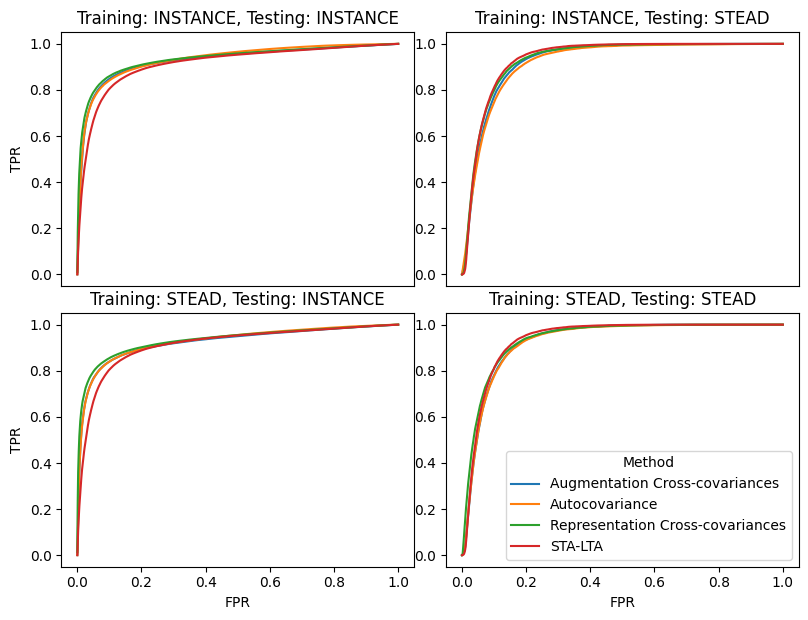

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
for train_idx, training_set in enumerate(["instance", "stead"]):
    for test_idx, test_set in enumerate(["instance", "stead"]):
        curve = curves[training_set + "_" + test_set]

        df_list = []
        for model in curve:
            df = pd.DataFrame(model)
            df["Method"] = method_aliases(model["name"])
            df_list.append(df)
        
        df = pd.concat(df_list)
        _df_list = []

        for name in df["name"].unique():
            fprs = []
            tprs = []
            for split in range(KFOLD):
                tprs.append(df[(df["name"] == name) & (df["split"] == split)]["tpr"].values)
                fprs.append(df[(df["name"] == name) & (df["split"] == split)]["fpr"].values)

            av_tpr, av_fpr = get_mean_roc(tprs, fprs)
            _df_list.append(pd.DataFrame({"name": name, "Method": method_aliases(name), "auc": auc(av_fpr, av_tpr), "tpr": av_tpr, "fpr": av_fpr}))

        _df = pd.concat(_df_list)
        print(_df)
        _df.rename(columns={"fpr": "FPR", "tpr": "TPR"}, inplace=True)
        
        if train_idx == 1 and test_idx == 1:
            sns.lineplot(data=_df, x='FPR', y='TPR', hue='Method', ax=axs[train_idx, test_idx], errorbar=None, alpha=1.0, linewidth=1.5)
        else:
            sns.lineplot(data=_df, x='FPR', y='TPR', hue='Method', ax=axs[train_idx, test_idx], errorbar=None, alpha=1.0, linewidth=1.5, legend=False)
            
        axs[train_idx, test_idx].set_title(f"Training: {training_set.upper()}, Testing: {test_set.upper()}")

        if train_idx == 0:
            axs[train_idx, test_idx].get_xaxis().set_visible(False)

        if test_idx == 1:
            axs[train_idx, test_idx].set_ylabel("")

plt.tight_layout(pad=0)
plt.savefig(PLOT_PATH, dpi=600)